Steps performed in this notebook:

**Cross-modal retrieval:** The combined latent space is assessed. For every query X, the latent space is searched for *n* amount of nearest target Y points using cosine or euclidean distance. These *n* amount of matches are then compared to the 'real' Y that corresponds to the query X by calculating the **tanimoto similarity** between the two respective structures. Out of all the tanimoto scores, the max one is taken and then used to make a distribution plot. And this is done for different amounts of nearest neighbours. Additionally, a random distribution is also plotted to show if the real distribution is better or worse than random.

In [50]:
import os
import pickle

# Load the CCA latent spaces for Spec2Vec and MS2DeepScore

def load_pickle(fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'rb') as f:
        df = pickle.load(f) 
    return df

data_path = '/lustre/BIF/nobackup/unen004/data'

df_spec2vec = load_pickle('dataframe_spec2vec', data_path)
df_ms2ds = load_pickle('dataframe_ms2deepscore', data_path)

In [51]:
path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings"
dataset = "ALL_GNPS_210409_positive"

# Load in tanimoto similarity matrix for comparisons later
tanimoto_fn = os.path.join(path, "datasets", dataset, 
                           "ALL_GNPS_210409_positive_tanimoto_scores.pickle")
with open(tanimoto_fn, "rb") as f:
    tanimoto_matrix = pickle.load(f)

## 3. Cross-modal retrieval
Here, the latent space will be utilized to do cross-modal retrieval using cosine similarity as a distance measure. In the ideal world, you would query a spectra, and then retrieve the structure that belongs to that spectra, but that is not always possible. Especially when using test data, for which the structures don't exist in the latent space, as the model is trained on the train data.

The number of neighbours is specified as a list. The distance metric can be either cosine or euclidean, or another one that is supported by `scipy.spatial.distance`.

First, for every spectral query the max number of structural nearest neighbours (nns) are found. E.g., if the highest number of nns in the `nn_list` is 100, then it will find 100 matches. The list can then later be shortened for the lower number of nns, instead of having to refind all the matches.

In [317]:
import heapq
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.spatial import distance

def get_matches_tanimoto(df_query, df_library, x='X', y='Y', nn=1, metric='cosine'):
    """For each query, get n nearest neighbours and all tanimoto scores 
    for each nearest neighbour. DFs are either df_train, df_test or df (both combined).
    """
    # Make distance matrix between X and Y
    cdist_matrix = distance.cdist([x for x in df_query[x]],
                                  [x for x in df_library[y]],
                                  metric=metric)
    
    # loop through each row in the dist matrix
    all_match_tanimoto_list = []
    all_rand_tanimoto_list = []
    for i, dist_list in enumerate(tqdm(cdist_matrix)): 
        # Get query info
        query = df_query.iloc[[i]]  # iloc looks by row number; 0, 1, 2...
        q_inchi = query.inchikey14.values[0]  # Get first 14 chars of inchikey of query
        
        # Turn distances into dataframe
        dist_df = pd.DataFrame(dist_list, columns=['dist'], index=df_library.inchikey14)
        
        # Add exception to exclude self-matches if x and y are the same
        #if x == y:
        if True:
            dist_df.drop(q_inchi, inplace=True)  # Remove self-match 
            
        # Sort on distance from small to high
        dist_df.sort_values(by='dist', inplace=True)
        
        # Take top n nearest neighbours, and keep only the inchikeys
        m_inchis = dist_df[:nn].index.values
        
        # Also get n random inchikey14 values
        r_inchis = df_library.sample(nn).inchikey14.values
        
        # Get tanimoto similarities of matches with query
        match_tanimoto_list = tanimoto_matrix[q_inchi][m_inchis].values
        rand_tanimoto_list = tanimoto_matrix[q_inchi][r_inchis].values
        
        all_match_tanimoto_list.append(match_tanimoto_list)
        all_rand_tanimoto_list.append(rand_tanimoto_list)

    return all_match_tanimoto_list, all_rand_tanimoto_list

def get_max_tanimoto(tanimoto_list, nn_list):
    """From list of e.g. 100 nn results, cut off list at certain points for plotting
    and then take the max tanimoto of those nearest neighbours.
    """
    max_tanimoto_dict = {}
    for nn in nn_list:  # Loop through nns
        max_tanimoto_list = []
        for all_tanimoto in tanimoto_list:  # Loop through matches
            curr_tanimoto = all_tanimoto[:nn]  # Cut off at certain spots
            max_tanimoto = max(curr_tanimoto)  # Get max over all nearest neighbours
            max_tanimoto_list.append(max_tanimoto)
        max_tanimoto_dict[nn] = max_tanimoto_list
    return pd.DataFrame(max_tanimoto_dict)

def perform_all_tanimoto_steps(df_query, df_library, nn_list, metric='cosine', x='X', y='Y', set_type='train'):
    """Perform all steps to get matches, get tanimoto similarity for each match, and 
    get max tanimoto similarity for each group of nearest neighbours.
    -------------------------
    nn_list: list of n nearest neighbours in inverse order
    metric: cosine, euclidean
    test: True or False"""
    
    # Find matches and get all n tanimoto scores query-match
    match_tanimoto_list, rand_tanimoto_list = get_matches_tanimoto(df_query, df_library, 
                                                                   x=x, y=y,
                                                                   nn=max(nn_list), metric=metric)

    # Get max tanimoto score for all nns
    match_df = get_max_tanimoto(match_tanimoto_list, nn_list)
    match_df['type'] = 'true'
    rand_df = get_max_tanimoto(rand_tanimoto_list, nn_list)
    rand_df['type'] = 'random'
    
    # Combine 'real' matches and 'random' matches
    comb_df = pd.concat([match_df, rand_df])
    
    # Add column to indicate if train or test data
    comb_df['set'] = set_type
        
    return comb_df

def get_tanimoto_df(df, nn_list, metric='cosine', x='X', y='Y'):
    """All the functions above are performed for train and test separately.
    """
    df_train = df[df['set'] == 'train']
    df_test = df[df['set'] == 'test']
    
    # Perform all the steps for both train and test
    train_tanimoto_df = perform_all_tanimoto_steps(df_train, df_train, nn_list, metric, x=x, y=y)
    # Test looks in the combined train and test latent space
    test_tanimoto_df = perform_all_tanimoto_steps(df_test, df, nn_list, metric, x=x, y=y, set_type='test')
    
    # Combine train and test 
    tanimoto_df = pd.concat([train_tanimoto_df, test_tanimoto_df])
    
    return tanimoto_df

In [318]:
# Prediction settings
nn_list = [1, 5, 10, 50, 100]
metric = 'cosine'

In [319]:
# Perform for both spectral and structural embeddings individually
tanimoto_df_spec2vec = get_tanimoto_df(df_spec2vec, nn_list, metric, x='spec2vec', y='spec2vec')
tanimoto_df_ms2ds = get_tanimoto_df(df_spec2vec, nn_list, metric, x='ms2ds', y='ms2ds')
#tanimoto_df_mol2vec = get_tanimoto_df(df_spec2vec, nn_list, metric, x='mol2vec', y='mol2vec')

# NOTE: df_spec2vec is used here, but df_ms2ds would've been the same, as the 
# only difference between the dataframes is the CCA latent spaces

  0%|          | 0/7293 [00:00<?, ?it/s]

  0%|          | 0/1824 [00:00<?, ?it/s]

  0%|          | 0/7293 [00:00<?, ?it/s]

  0%|          | 0/1824 [00:00<?, ?it/s]

In [320]:
# Perform for both spec2vec and ms2deepscore CCA latent spaces
tanimoto_df_spec2vec_cca = get_tanimoto_df(df_spec2vec, nn_list, metric)
tanimoto_df_ms2ds_cca = get_tanimoto_df(df_ms2ds, nn_list, metric)

  0%|          | 0/7293 [00:00<?, ?it/s]

  0%|          | 0/1824 [00:00<?, ?it/s]

  0%|          | 0/7293 [00:00<?, ?it/s]

  0%|          | 0/1824 [00:00<?, ?it/s]

### Plots
The plot below shows that the 'real' distribution, the green one, does *much* better than the random distribution, especially for the higher nearest neighbours. The method shown here is the spec2vec, without CCA, but this is true for all methods.

In [321]:
# Make distribution plots
def make_distribution_plot(tanimoto_df):
    tanimoto_df_m = tanimoto_df.melt(id_vars=['set', 'type'],
                                     var_name='nn', value_name='tanimoto')
    g = sns.FacetGrid(tanimoto_df_m, 
                      row='nn', col='set', hue='type',
                      aspect=4, height=1.5, palette=["C2", "C7"])
    g.map(sns.kdeplot, 'tanimoto', bw_adjust=0.7, shade=True, alpha=0.5)
    g.add_legend()
    
#make_distribution_plot(tanimoto_df_spec2vec)

Now combining the spec2vec and ms2ds dataframes to plot them next to each other.

In [322]:
# Combine into one dataframe for plotting
tanimoto_df_spec2vec['spectral'] = 'spec2vec'
tanimoto_df_spec2vec_cca['spectral'] = 'spec2vec_cca'
tanimoto_df_ms2ds['spectral'] = 'ms2ds'
tanimoto_df_ms2ds_cca['spectral'] = 'ms2ds_cca'
#tanimoto_df_mol2vec_no_cca['spectral'] = 'mol2vec'

tanimoto_df = pd.concat([tanimoto_df_spec2vec, tanimoto_df_spec2vec_cca, 
                         tanimoto_df_ms2ds, tanimoto_df_ms2ds_cca])
tanimoto_df = tanimoto_df[tanimoto_df.type != 'random'] # remove random
tanimoto_df = tanimoto_df.drop('type', axis=1)
tanimoto_df.head()

,1,5,10,50,100,set,spectral
0,0.499634,0.500000,0.518717,0.950000,0.950000,train,spec2vec
1,0.597630,0.996139,0.996139,0.996139,0.996139,train,spec2vec
2,0.324985,0.593291,0.615463,0.615463,0.615463,train,spec2vec
3,0.411413,0.411413,0.448436,0.524830,0.538385,train,spec2vec
4,0.857853,0.925447,0.925447,0.925447,0.925447,train,spec2vec


In [323]:
tanimoto_df_m = tanimoto_df.melt(id_vars=['set', 'spectral'], var_name='nn', value_name='tanimoto')
tanimoto_df_m

,set,spectral,nn,tanimoto
0,train,spec2vec,1,0.499634
1,train,spec2vec,1,0.597630
2,train,spec2vec,1,0.324985
3,train,spec2vec,1,0.411413
4,train,spec2vec,1,0.857853
...,...,...,...,...
182335,test,ms2ds_cca,100,0.985759
182336,test,ms2ds_cca,100,0.892142
182337,test,ms2ds_cca,100,0.054248
182338,test,ms2ds_cca,100,0.349398


These plots show that in general, MS2DeepScore does better for low amounts of nearest neighbours, and Spec2Vec does better for high amount of nearest neighbours.

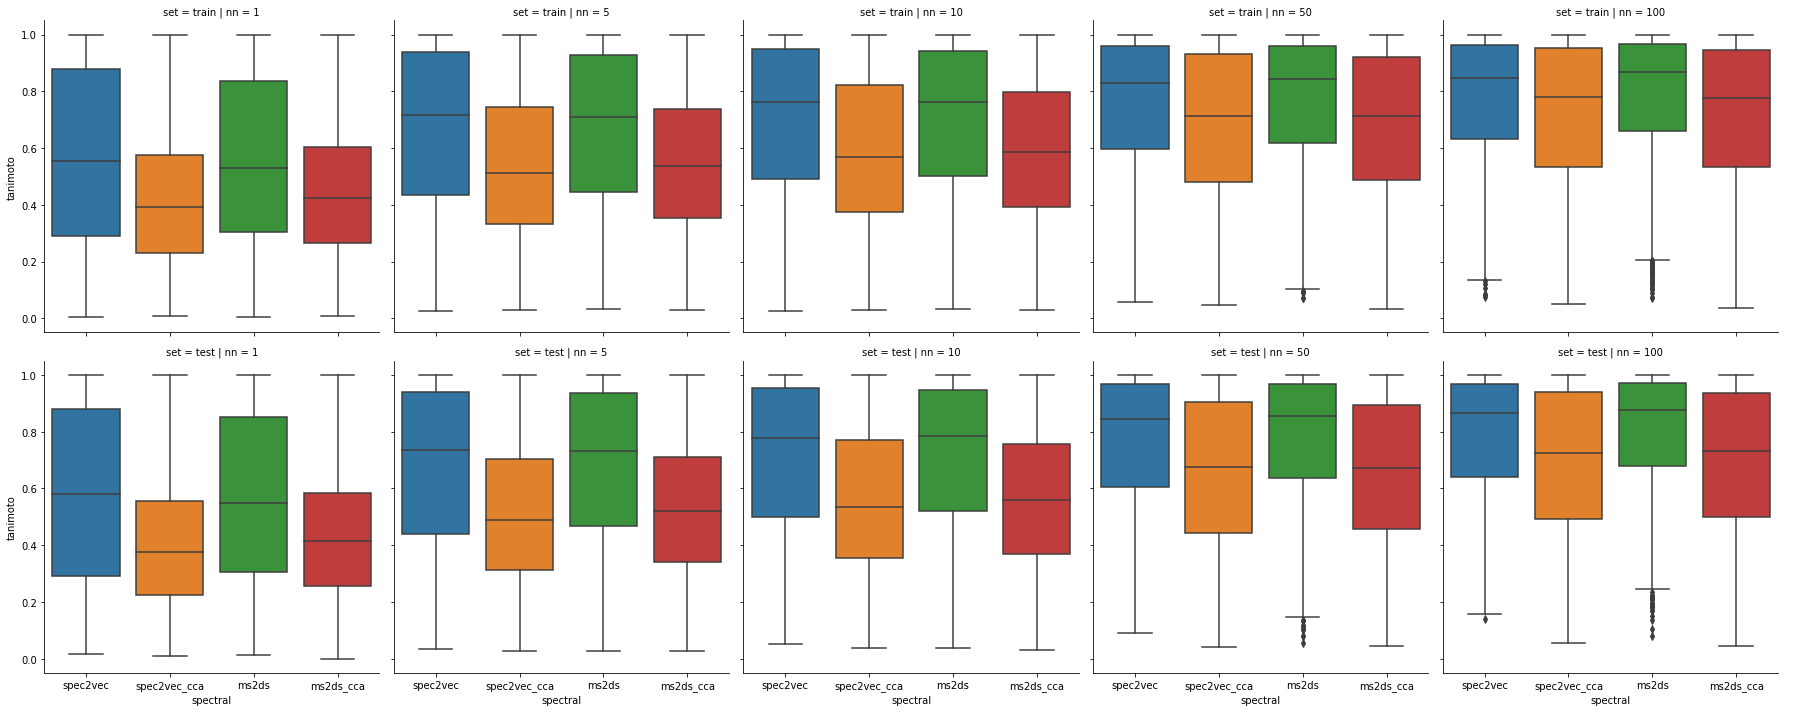

In [324]:
import seaborn as sns

# Boxplot to show difference between spec2vec and ms2deepscore 
g = sns.catplot(data=tanimoto_df_m, x='spectral', y='tanimoto', col='nn', row='set', kind='box')#, palette=["C4", "C6"])
g.add_legend()

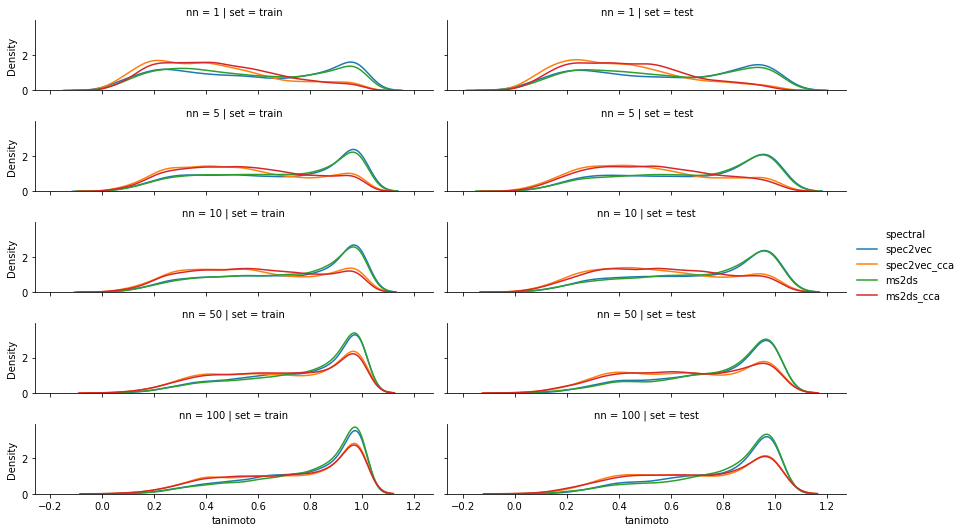

In [325]:
tanimoto_df_m = tanimoto_df.melt(id_vars=['set', 'spectral'],
                                 var_name='nn', value_name='tanimoto')
g = sns.FacetGrid(tanimoto_df_m, 
                  row='nn', col='set', hue='spectral',
                  aspect=4, height=1.5)#, palette=["C2", "C7"])
g.map(sns.kdeplot, 'tanimoto')#, bw_adjust=0.7, shade=True, alpha=0.5)
g.add_legend()